In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import folium
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

# Settings
import matplotlib


In [2]:
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))

# Read data
train_data = pd.read_csv('../input/train.csv')


# View data
train_data.head()

,id,id_sofer,data_pornire,data_sosire,nr_pasageri,longitudine_pornire,latitudine_pornire,longitudine_sosire,latitudine_sosire,cursa_marcata,durata_cursa
0,id2875421,2,14-03-16 17:24,14-03-16 17:32,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,12-06-16 00:43,12-06-16 00:54,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,19-01-16 11:35,19-01-16 12:10,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,06-04-16 19:32,06-04-16 19:39,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,26-03-16 13:30,26-03-16 13:38,1,-73.973,40.793,-73.973,40.783,N,435


In [3]:
print('Data Shape',train_data.shape)
train_data.info()

Data Shape (1048575, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
id                     1048575 non-null object
id_sofer               1048575 non-null int64
data_pornire           1048575 non-null object
data_sosire            1048575 non-null object
nr_pasageri            1048575 non-null int64
longitudine_pornire    1048575 non-null float64
latitudine_pornire     1048575 non-null float64
longitudine_sosire     1048575 non-null float64
latitudine_sosire      1048575 non-null float64
cursa_marcata          1048575 non-null object
durata_cursa           1048575 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 88.0+ MB


In [4]:
# Statistical summary
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_sofer,1048575.000,1.535,0.499,1.000,1.000,2.000,2.000,2.000
nr_pasageri,1048575.000,1.664,1.314,0.000,1.000,1.000,2.000,9.000
longitudine_pornire,1048575.000,-73.973,0.043,-78.547,-73.992,-73.982,-73.967,-61.336
latitudine_pornire,1048575.000,40.751,0.034,34.360,40.737,40.754,40.768,51.881
longitudine_sosire,1048575.000,-73.973,0.043,-79.818,-73.991,-73.980,-73.963,-61.336
latitudine_sosire,1048575.000,40.752,0.036,32.181,40.736,40.755,40.770,43.912
durata_cursa,1048575.000,962.145,5853.002,1.000,397.000,662.000,1075.000,3526282.000


In [5]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = train_data[((train_data.latitudine_pornire <= 40.5774) | (train_data.longitudine_pornire <= -74.15) | (train_data.latitudine_pornire >= 40.9176) | (train_data.longitudine_pornire >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["latitudine_pornire"] != 0:
        folium.Marker([j["latitudine_pornire"], j["longitudine_pornire"]]).add_to(m)
m

In [6]:
# Remove passenger_count outliers
train_data = train_data[train_data['nr_pasageri']>0]
train_data = train_data[train_data['nr_pasageri']<9]

# train_data = train_data[train_data['pickup_longitude'] <= -73.968285]
# train_data = train_data[train_data['pickup_longitude'] >= -74.0059]
# train_data = train_data[train_data['pickup_latitude'] <= 40.748817]
# train_data = train_data[train_data['pickup_latitude'] >= 40.7128]
# train_data = train_data[train_data['dropoff_longitude'] <= -73.968285]
# train_data = train_data[train_data['dropoff_longitude'] >= -74.0059]
# train_data = train_data[train_data['dropoff_latitude'] <= 40.748817]
# train_data = train_data[train_data['dropoff_latitude'] >= 40.7128]

# Remove coordinate outliers
train_data = train_data[train_data['longitudine_pornire'] <= -73.75]
train_data = train_data[train_data['longitudine_pornire'] >= -74.03]
train_data = train_data[train_data['latitudine_pornire'] <= 40.85]
train_data = train_data[train_data['latitudine_pornire'] >= 40.63]
train_data = train_data[train_data['longitudine_sosire'] <= -73.75]
train_data = train_data[train_data['longitudine_sosire'] >= -74.03]
train_data = train_data[train_data['latitudine_sosire'] <= 40.85]
train_data = train_data[train_data['latitudine_sosire'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(train_data['durata_cursa'])
trip_duration_std = np.std(train_data['durata_cursa'])
train_data = train_data[train_data['durata_cursa']<=trip_duration_mean + 2*trip_duration_std]
train_data = train_data[train_data['durata_cursa']>= trip_duration_mean - 2*trip_duration_std]

# Confirm removal
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_sofer,1033016.000,1.534,0.499,1.000,1.000,2.000,2.000,2.000
nr_pasageri,1033016.000,1.664,1.314,1.000,1.000,1.000,2.000,6.000
longitudine_pornire,1033016.000,-73.974,0.037,-74.030,-73.992,-73.982,-73.967,-73.751
latitudine_pornire,1033016.000,40.751,0.027,40.630,40.737,40.754,40.768,40.850
longitudine_sosire,1033016.000,-73.974,0.033,-74.030,-73.991,-73.980,-73.963,-73.750
latitudine_sosire,1033016.000,40.752,0.030,40.630,40.736,40.755,40.770,40.850
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [7]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = train_data[((train_data.latitudine_pornire <= 40.5774) | (train_data.longitudine_pornire <= -74.15) | (train_data.latitudine_pornire >= 40.9176) | (train_data.longitudine_pornire >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["latitudine_pornire"] != 0:
        folium.Marker([j["latitudine_pornire"], j["longitudine_pornire"]]).add_to(m)
m

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 11 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
data_pornire           1033016 non-null object
data_sosire            1033016 non-null object
nr_pasageri            1033016 non-null int64
longitudine_pornire    1033016 non-null float64
latitudine_pornire     1033016 non-null float64
longitudine_sosire     1033016 non-null float64
latitudine_sosire      1033016 non-null float64
cursa_marcata          1033016 non-null object
durata_cursa           1033016 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 94.6+ MB


In [9]:
train_data['data_timp_pornire'] = pd.to_datetime(train_data.data_pornire) # Pickups
train_data['data_timp_sosire'] = pd.to_datetime(train_data.data_sosire) # Drop-offs

# Confirm changes
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 13 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
data_pornire           1033016 non-null object
data_sosire            1033016 non-null object
nr_pasageri            1033016 non-null int64
longitudine_pornire    1033016 non-null float64
latitudine_pornire     1033016 non-null float64
longitudine_sosire     1033016 non-null float64
latitudine_sosire      1033016 non-null float64
cursa_marcata          1033016 non-null object
durata_cursa           1033016 non-null int64
data_timp_pornire      1033016 non-null datetime64[ns]
data_timp_sosire       1033016 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 110.3+ MB


In [10]:
print(train_data['data_timp_pornire'].dt.date)

0          2016-03-14
1          2016-12-06
2          2016-01-19
3          2016-06-04
4          2016-03-26
5          2016-01-30
6          2016-06-17
7          2016-05-21
8          2016-05-27
9          2016-10-03
10         2016-10-05
11         2016-05-15
12         2016-02-19
13         2016-01-06
14         2016-05-27
15         2016-05-16
16         2016-11-04
17         2016-04-14
18         2016-06-27
19         2016-05-06
20         2016-02-28
21         2016-01-04
22         2016-09-04
23         2016-06-25
24         2016-03-06
25         2016-02-14
26         2016-02-27
27         2016-06-20
28         2016-06-13
29         2016-03-23
              ...    
1048545    2016-01-14
1048546    2016-03-16
1048547    2016-05-15
1048548    2016-09-04
1048549    2016-05-17
1048550    2016-07-05
1048551    2016-07-01
1048552    2016-05-25
1048553    2016-12-06
1048554    2016-04-02
1048555    2016-02-24
1048556    2016-09-05
1048557    2016-03-05
1048558    2016-04-23
1048559   

In [11]:
# Delimit pickup_datetime variable 

train_data['data_pornire'] = train_data['data_timp_pornire'].dt.date # Extract date
train_data['timp_pornire'] = train_data['data_timp_pornire'].dt.time # Extract time

# Delimit dropoff_datetime variables
train_data['data_sosire'] = train_data['data_timp_sosire'].dt.date # Extract date
train_data['timp_sosire'] = train_data['data_timp_sosire'].dt.time # Extract time

# Additional pickup features
train_data['luna_pornire'] = train_data['data_timp_pornire'].dt.month # Extract month
# train_data['pickup_month'] = train_data.pickup_datetime.dt.to_period('M') # Extract yearmonth
#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
train_data['ora_pornire'] = train_data['data_timp_pornire'].dt.hour # Extract hour
train_data['ziua_pornire'] = train_data['data_timp_pornire'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
train_data.drop(['data_pornire'], axis = 1, inplace = True)
train_data.drop(['data_sosire'], axis = 1, inplace = True)

# Confirm changes
train_data.columns

Index(['id', 'id_sofer', 'nr_pasageri', 'longitudine_pornire',
       'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
       'cursa_marcata', 'durata_cursa', 'data_timp_pornire',
       'data_timp_sosire', 'timp_pornire', 'timp_sosire', 'luna_pornire',
       'ora_pornire', 'ziua_pornire'],
      dtype='object')

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 16 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
nr_pasageri            1033016 non-null int64
longitudine_pornire    1033016 non-null float64
latitudine_pornire     1033016 non-null float64
longitudine_sosire     1033016 non-null float64
latitudine_sosire      1033016 non-null float64
cursa_marcata          1033016 non-null object
durata_cursa           1033016 non-null int64
data_timp_pornire      1033016 non-null datetime64[ns]
data_timp_sosire       1033016 non-null datetime64[ns]
timp_pornire           1033016 non-null object
timp_sosire            1033016 non-null object
luna_pornire           1033016 non-null int64
ora_pornire            1033016 non-null int64
ziua_pornire           1033016 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(6), object(4)
memory usage: 134.0+ MB


In [13]:
print(train_data['timp_pornire'][0])
print(train_data['timp_sosire'][0])

17:24:00
17:32:00


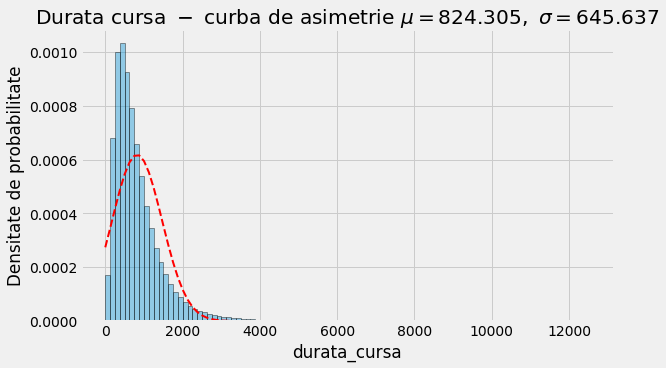

,count,mean,std,min,25%,50%,75%,max
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [14]:
# Mean distribution
mu = train_data['durata_cursa'].mean()

# Std distribution
sigma = train_data['durata_cursa'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train_data['durata_cursa'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('durata_cursa')
plt.ylabel('Densitate de probabilitate')

# Adding a title
plt.title(r'$\mathrm{Durata\ cursa\ -\ curba\ de\ asimetrie}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

# Statistical summary
train_data.describe()[['durata_cursa']].transpose()

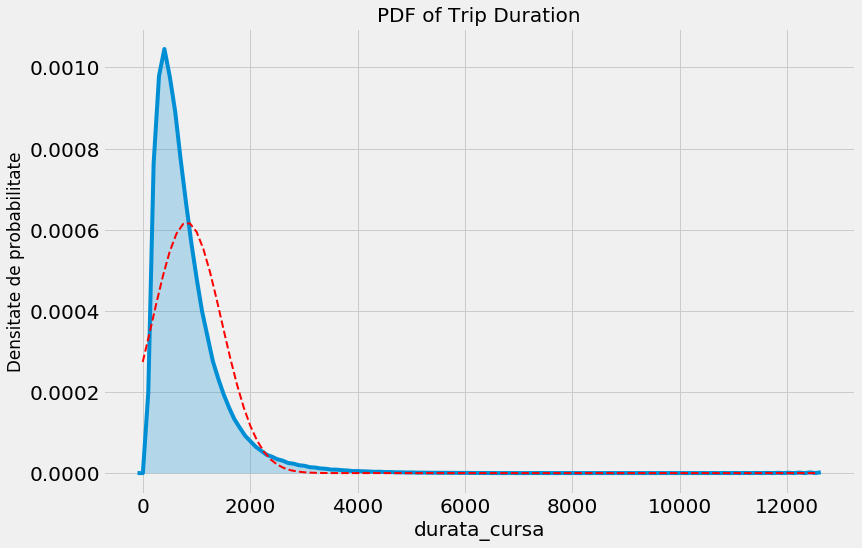

,count,mean,std,min,25%,50%,75%,max
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [15]:
mu = train_data['durata_cursa'].mean()
sigma = train_data['durata_cursa'].std()
num_bins = 100


plt.figure(figsize = (12,8))
sns.kdeplot(train_data['durata_cursa'].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("PDF of Trip Duration", fontsize = 20)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.tick_params(labelsize = 20)
plt.xlabel('durata_cursa')
plt.ylabel('Densitate de probabilitate')

plt.show()


# Statistical summary
train_data.describe()[['durata_cursa']].transpose()

In [16]:
train_data.columns

Index(['id', 'id_sofer', 'nr_pasageri', 'longitudine_pornire',
       'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
       'cursa_marcata', 'durata_cursa', 'data_timp_pornire',
       'data_timp_sosire', 'timp_pornire', 'timp_sosire', 'luna_pornire',
       'ora_pornire', 'ziua_pornire'],
      dtype='object')

In [17]:
train_data.groupby('data_timp_pornire').count()['id'].sort_values(ascending = True)[[0]]


data_timp_pornire
2016-04-21 03:39:00    1
Name: id, dtype: int64

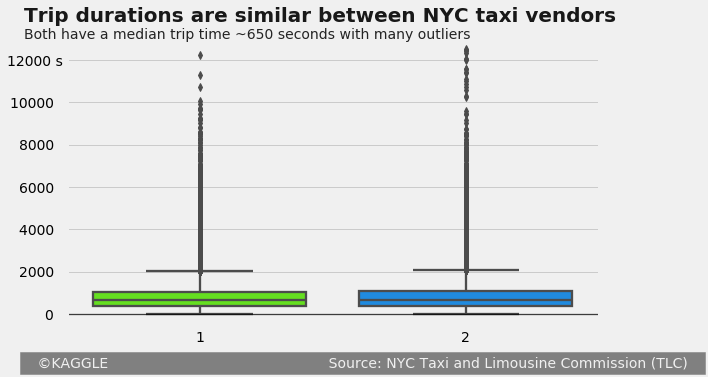

,count,mean,std,min,25%,50%,75%,max
id_sofer,,,,,,,,
1,481547.000,818.493,637.824,1.000,392.000,652.000,1052.000,12218.000
2,551469.000,829.380,652.342,1.000,395.000,657.000,1060.000,12527.000


In [18]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'id_sofer', y = 'durata_cursa', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# # Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = "Trip durations are similar between NYC taxi vendors",
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = 'Both have a median trip time ~650 seconds with many outliers',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('id_sofer')['durata_cursa'].describe()

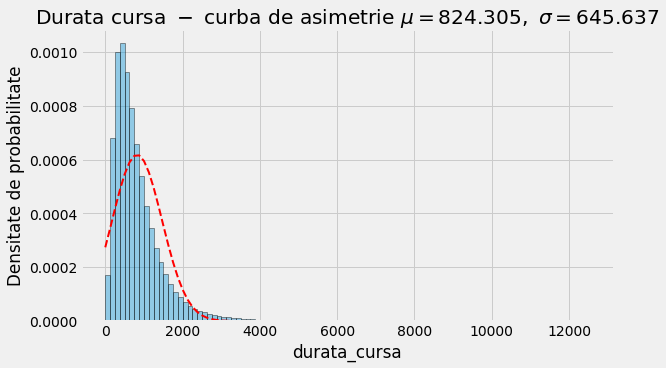

,count,mean,std,min,25%,50%,75%,max
durata_cursa,1033016.000,824.305,645.637,1.000,394.000,655.000,1056.000,12527.000


In [19]:
# Mean distribution
mu = train_data['durata_cursa'].mean()

# Std distribution
sigma = train_data['durata_cursa'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train_data['durata_cursa'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('durata_cursa')
plt.ylabel('Densitate de probabilitate')

# Adding a title
plt.title(r'$\mathrm{Durata\ cursa\ -\ curba\ de\ asimetrie}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

# Statistical summary
train_data.describe()[['durata_cursa']].transpose()

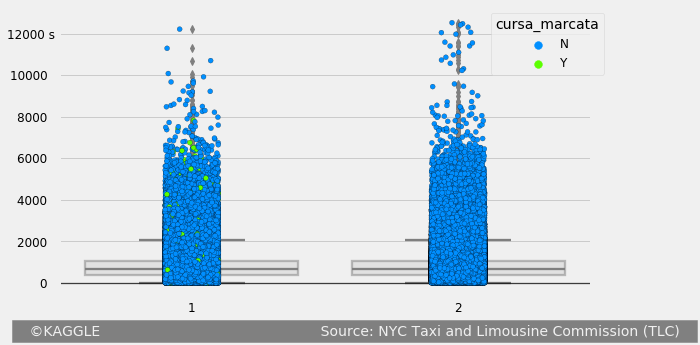

cursa_marcata,N,Y
id_sofer,,
1,475856.000,5691.000
2,551469.000,0.000


In [20]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'id_sofer', y = 'durata_cursa', data = train_data, 
                          orient = 'v',color = 'lightgrey', linewidth = 2.3)
plt.setp(vendor_graph.artists, alpha = 0.5)

# Create strip plot
sns.stripplot(data = train_data, x = 'id_sofer', y = 'durata_cursa', jitter = 1, size = 5,
             edgecolor = 'black', linewidth = .2,palette = 'gist_rainbow_r',hue = 'cursa_marcata')

# Customize tick size
vendor_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = '',
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = '',
              fontsize = 14, alpha = .85)
# Format legend
vendor_graph.legend(title = 'cursa_marcata', bbox_to_anchor = (.80,1),loc = 2, fontsize=12)
plt.show()

# Statistical summary
train_data.groupby(['id_sofer','cursa_marcata'])['cursa_marcata'].count().unstack().fillna(0)

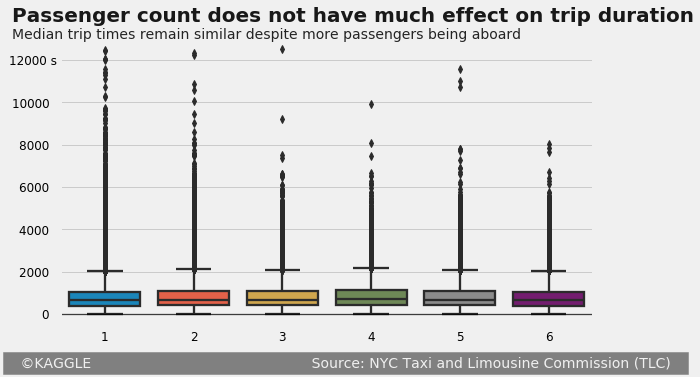

nr_pasageri,1,2,3,4,5,6
count,732436.000,148582.000,42372.000,20018.000,55414.000,34194.000
mean,812.850,864.329,849.477,875.144,832.031,822.277
std,635.321,684.842,653.908,687.584,648.245,640.025
min,1.000,1.000,2.000,2.000,2.000,3.000
25%,388.000,412.000,414.000,421.000,398.000,393.000
50%,647.000,679.000,676.000,691.000,661.000,653.000
75%,1044.000,1100.000,1085.000,1120.000,1062.000,1055.000
max,12480.000,12313.000,12527.000,9922.000,11591.000,8041.000


In [21]:
# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'nr_pasageri', y = 'durata_cursa', data = train_data, linewidth = 2.3, orient='v')
passenger_graph.tick_params(labelsize = 20)
# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
passenger_graph.xaxis.label.set_visible(False)
passenger_graph.yaxis.label.set_visible(False)

# Add signature bar
passenger_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('nr_pasageri')['durata_cursa'].describe().transpose()

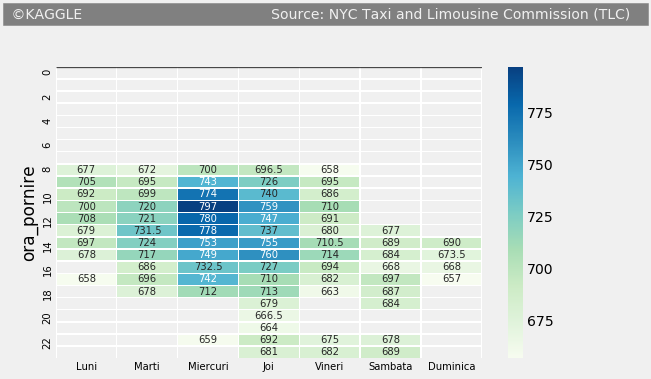

In [22]:
# Trips by Hour and Day of Week
trip_duration_median = train_data['durata_cursa'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train_data.groupby(['ora_pornire','ziua_pornire'])['durata_cursa'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Luni', 'Marti', 'Miercuri','Joi','Vineri','Sambata','Duminica'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
hourday_graph.text(x = -.8,  y = -4,
                   s = ' ©KAGGLE                                          Source: NYC Taxi and Limousine Commission (TLC)   ',
fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# plt.ylabel('pickup_hour (military time)')
# plt.xlabel('pickup_weekday (Mon - Sun)')
# plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

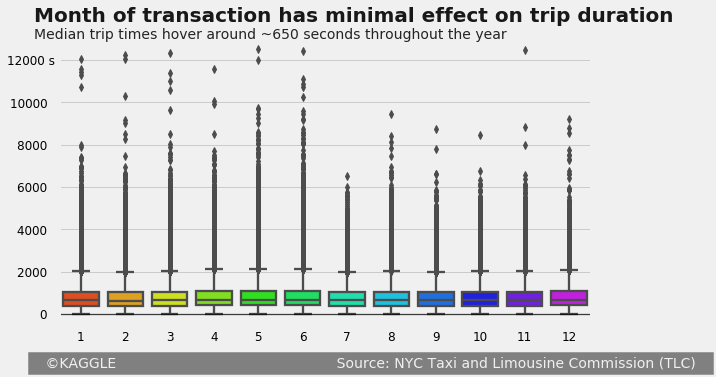

luna_pornire,1,2,3,4,5,6,7,8,9,10,11,12
count,133267.000,133657.000,142991.000,140752.000,141297.000,132734.000,34652.000,34161.000,35162.000,34609.000,34474.000,35260.000
mean,812.014,784.607,811.045,838.201,857.675,852.870,797.942,825.969,809.655,811.118,822.743,831.672
std,628.261,591.891,630.581,648.388,692.619,687.892,595.242,664.623,626.856,628.993,644.012,647.902
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,1.000,2.000
25%,394.000,382.000,389.000,400.000,401.000,402.000,390.000,390.000,391.000,388.000,393.000,398.000
50%,648.000,632.000,646.000,668.000,673.000,669.000,646.000,646.000,647.000,646.000,653.000,663.000
75%,1040.000,1014.000,1042.000,1080.000,1096.000,1085.000,1025.000,1053.000,1032.000,1046.000,1052.000,1069.000
max,12051.000,12218.000,12313.000,11556.000,12527.000,12419.000,6517.000,9462.000,8716.000,8460.000,12480.000,9223.000


In [23]:
# Box plot of pickups by month
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
month_graph = sns.boxplot(x = 'luna_pornire', y = 'durata_cursa', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
month_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
month_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
month_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

# Add signature bar
month_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
month_graph.text(x =-1.05, y = 13800, s = "Month of transaction has minimal effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
month_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times hover around ~650 seconds throughout the year',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('luna_pornire')['durata_cursa'].describe().transpose()

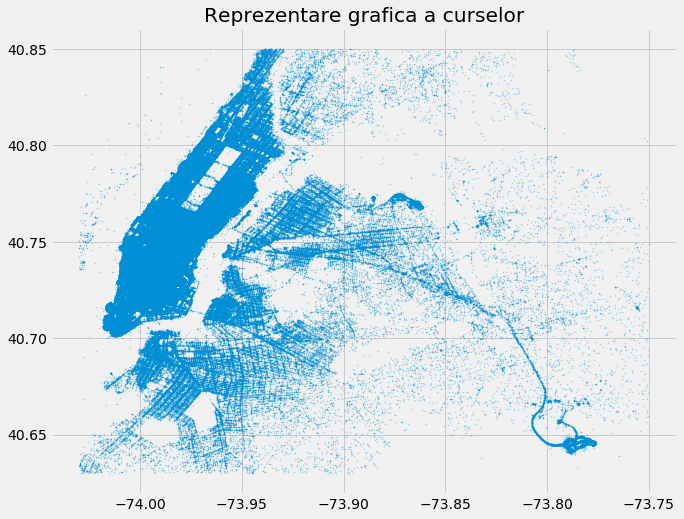

In [24]:
longitude = list(train_data.longitudine_pornire) + list(train_data.longitudine_sosire)
latitude = list(train_data.latitudine_pornire) + list(train_data.latitudine_sosire)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Reprezentare grafica a curselor')
plt.show()

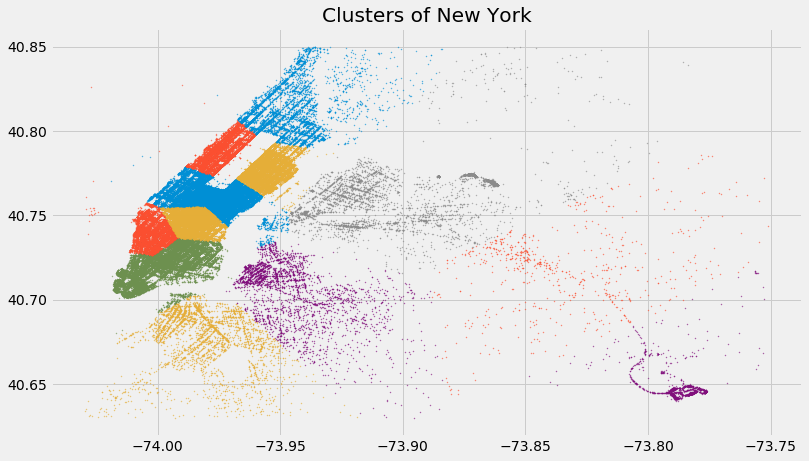

In [25]:
# Create data frame of coordinates
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

# Clusters of New York
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
loc_df = loc_df.sample(200000)
plt.figure(figsize = (12,7))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.8, markersize = 0.8)
plt.title('Clusters of New York')
plt.show()

List the numerical features in decending order by their correlation with trip_duration:

longitudine_pornire: 0.36241596694672223
longitudine_sosire: 0.2543550906959195
latitudine_pornire: -0.23578933817563946
latitudine_sosire: -0.196500196851999
ora_pornire: 0.030887792384612332
ziua_pornire: -0.0215554032223168
nr_pasageri: 0.014259878789089622
luna_pornire: 0.01202331281575298


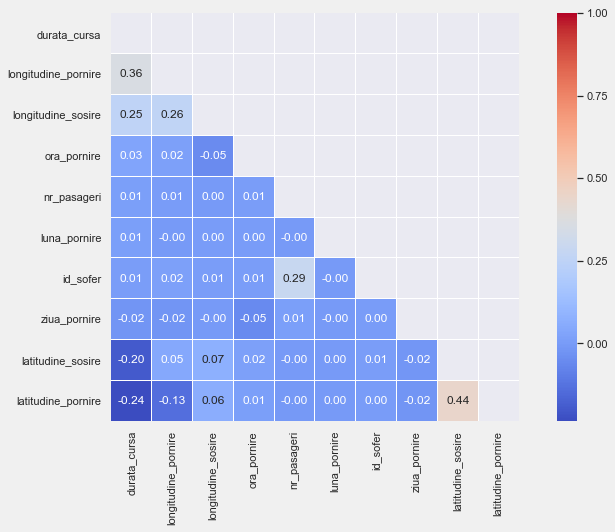

In [26]:
# Correlations to trip_duration
corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['durata_cursa'].to_dict()
del cor_dict['durata_cursa']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train_data.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'durata_cursa')['durata_cursa'].index
cm = np.corrcoef(train_data[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

In [27]:
train_data.head()

,id,id_sofer,nr_pasageri,longitudine_pornire,latitudine_pornire,longitudine_sosire,latitudine_sosire,cursa_marcata,durata_cursa,data_timp_pornire,data_timp_sosire,timp_pornire,timp_sosire,luna_pornire,ora_pornire,ziua_pornire
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14 17:24:00,2016-03-14 17:32:00,17:24:00,17:32:00,3,17,0
1,id2377394,1,1,-73.980,40.739,-73.999,40.731,N,663,2016-12-06 00:43:00,2016-12-06 00:54:00,00:43:00,00:54:00,12,0,1
2,id3858529,2,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19 11:35:00,2016-01-19 12:10:00,11:35:00,12:10:00,1,11,1
3,id3504673,2,1,-74.010,40.720,-74.012,40.707,N,429,2016-06-04 19:32:00,2016-06-04 19:39:00,19:32:00,19:39:00,6,19,5
4,id2181028,2,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26 13:30:00,2016-03-26 13:38:00,13:30:00,13:38:00,3,13,5


In [28]:
train_data['cursa_marcata'] = train_data['cursa_marcata'].map({'N':0,'Y':1})


In [29]:
print(train_data)

                id  id_sofer  nr_pasageri  longitudine_pornire  \
0        id2875421         2            1              -73.982   
1        id2377394         1            1              -73.980   
2        id3858529         2            1              -73.979   
3        id3504673         2            1              -74.010   
4        id2181028         2            1              -73.973   
5        id0801584         2            6              -73.983   
6        id1813257         1            4              -73.969   
7        id1324603         2            1              -73.969   
8        id1301050         1            1              -73.999   
9        id0012891         2            1              -73.981   
10       id1436371         2            1              -73.983   
11       id1299289         2            4              -73.992   
12       id1187965         2            2              -73.963   
13       id0799785         2            1              -73.956   
14       i

In [30]:
train_data.drop(['data_timp_pornire','timp_pornire','data_timp_sosire', 'timp_sosire','id'], 
                axis = 1, inplace = True)

In [31]:
train_data.columns

Index(['id_sofer', 'nr_pasageri', 'longitudine_pornire', 'latitudine_pornire',
       'longitudine_sosire', 'latitudine_sosire', 'cursa_marcata',
       'durata_cursa', 'luna_pornire', 'ora_pornire', 'ziua_pornire'],
      dtype='object')

In [40]:
# Split
# Create matrix of features
X = train_data[['id_sofer', 'nr_pasageri', 'longitudine_pornire',
       'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
       'luna_pornire', 'ora_pornire',
       'ziua_pornire']] # double brackets!

# Create array of target variable 
y = train_data['durata_cursa']

# Create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [44]:
# Fit
# Import model
from sklearn.tree import DecisionTreeRegressor

# Instantiate model object
dtree = DecisionTreeRegressor(max_depth=8)

# Fit to training data
dtree.fit(X_train,y_train)
print(dtree)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score It
from sklearn import metrics
print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.r2_score(y_test,y_pred_dtree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_dtree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_dtree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_dtree)))

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Decision Tree Regression Performance Metrics
R^2= 0.517780313602999
MAE: 326.560078361917
MSE: 1.9905415918354448
RMSE: 446.15486009181217


------------------
id_sofer                2.000
nr_pasageri             2.000
longitudine_pornire   -73.974
latitudine_pornire     40.762
longitudine_sosire    -73.963
latitudine_sosire      40.768
luna_pornire            1.000
ora_pornire            15.000
ziua_pornire            3.000
Name: 125647, dtype: float64


NameError: name 'rforest' is not defined

In [ ]:
# Load test data
test_data = pd.read_csv('./input/test_c.csv')

# Test data info
test_data.info()

# Test data shape
print('shape',test_data.shape)
print(test_data)

In [ ]:
# Convert timestamps to date objects
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime) # Pickups

# Delimit pickup_datetime variable 
test_data['pickup_date'] = test_data['pickup_datetime'].dt.date # Extract date
test_data['pickup_time'] = test_data['pickup_datetime'].dt.time # Extract time

# Additional pickup features
test_data['pickup_month'] = test_data['pickup_datetime'].dt.month # Extract month

#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour # Extract hour
test_data['pickup_weekday'] = test_data['pickup_datetime'].dt.dayofweek # Extract day of week

# Encode categorical variables
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].map({'N':0,'Y':1})

In [ ]:
X_test= test_data[['passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']]

# Feed features into random forest
y_pred= dtree.predict(X_test)
print(y_pred[0])
submission = pd.DataFrame({
    'trip_duration': y_pred
})

print(submission)

In [ ]:
# Create contest submission
submission = pd.DataFrame({
    'Id':test_data['id'],
    'trip_duration': y_pred
})
submission.to_csv('mytaxisubmission.csv',index = False)

In [ ]:
#  Import model
from sklearn.linear_model import LinearRegression

#  Instantiate model object
lreg = LinearRegression()

# Fit to training data
lreg.fit(X_train,y_train)
print(lreg)

# Predict
y_pred_lreg = lreg.predict(X_test)

# Score It
from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_lreg))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_lreg))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_lreg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lreg)))

In [ ]:
# Fit 
# Import model
from sklearn.ensemble import RandomForestRegressor 

# Instantiate model object
rforest = RandomForestRegressor(n_estimators = 100, n_jobs = -1, max_depth = 16)

# Fit to training data
rforest = rforest.fit(X_train,y_train)
print(rforest)

# Predict
y_pred_rforest = rforest.predict(X_test)
print(y_pred_rforest)
# Score It
from sklearn import metrics
print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_test,y_pred_rforest))
print('MAE',metrics.mean_absolute_error(y_test, y_pred_rforest))
print('MSE',metrics.mean_squared_error(y_test, y_pred_rforest))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rforest)))